In [1]:
from patsy import *
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import pgmpy
import scipy.stats

# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

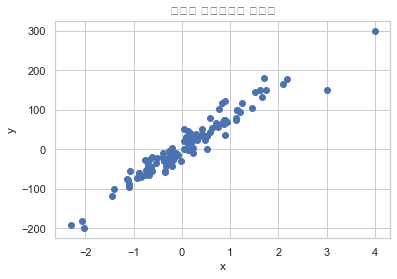

In [2]:
from sklearn.datasets import make_regression

# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=1)

# 레버리지가 높은 가상의 데이터를 추가
data_100 = (4, 300)
data_101 = (3, 150)
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])
X = sm.add_constant(X0)
y = np.hstack([y, [data_100[1], data_101[1]]])

plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("가상의 회귀분석용 데이터")
plt.show()

In [3]:
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Sat, 08 Aug 2020   Prob (F-statistic):           1.61e-61
Time:                        12:58:20   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

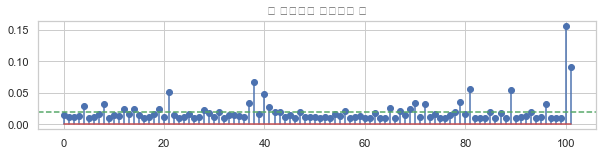

In [4]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.axhline(0.02, c="g", ls="--")
plt.title("각 데이터의 레버리지 값")
plt.show()

In [5]:
hat.sum()

2.0000000000000004

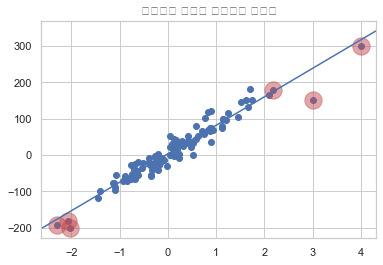

In [6]:
ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)

idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.title("회귀분석 결과와 레버리지 포인트")
plt.show()

### 레버리지의 영향

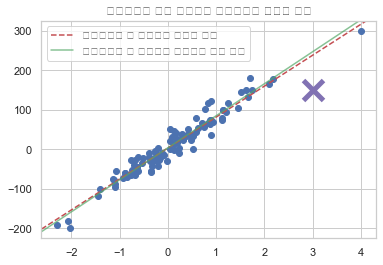

In [9]:
# 레버리지가 큰 데이터가 회귀분석에 미치는 영향
model2 = sm.OLS(y[:-1], X[:-1])
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result2,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-1], y[-1], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 큰 데이터를 포함한 경우", u"레버리지가 큰 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지가 높은 데이터가 회귀분석에 미치는 영향")
plt.show()

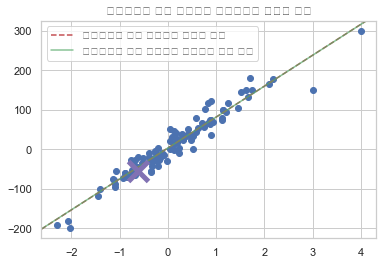

In [8]:
# 레버리지가 작은 데이터가 회귀분석에 미치는 영향
model3 = sm.OLS(y[1:], X[1:])
result3 = model3.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result3,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[0], y[0], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 작은 데이터를 포함한 경우", u"레버리지가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()

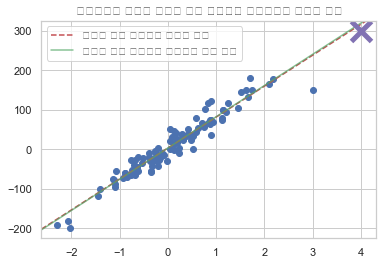

In [10]:
# 레버리지는 높지만 오차가 작은 데이터가 회귀분석에 미치는 영향
idx = np.array(list(range(100)) + [101])
model4 = sm.OLS(y[idx], X[idx, :])
result4 = model4.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result4,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend([u"오차가 작은 데이터를 포함한 경우", u"오차가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지는 높지만 오차가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()

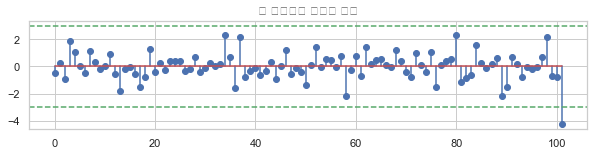

In [12]:
# 각 데이터의 표준화 잔차
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.axhline(3, c="g", ls="--")
plt.axhline(-3, c="g", ls="--")
plt.title("각 데이터의 표준화 잔차")
plt.show()

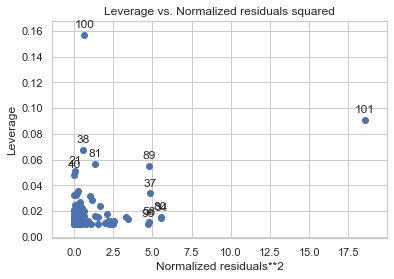

In [13]:
# Cook's Distance
sm.graphics.plot_leverage_resid2(result)
plt.show()

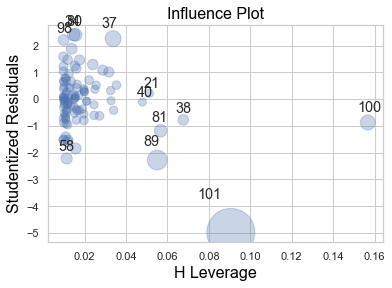

In [14]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

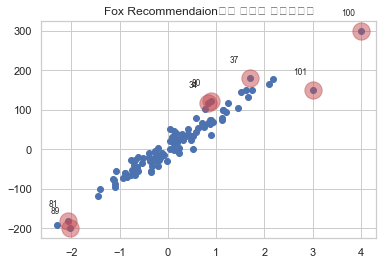

In [16]:
# Fox Recommendaion으로 선택한 아웃라이어
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(X0, y)
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("Fox Recommendaion으로 선택한 아웃라이어")
plt.show()

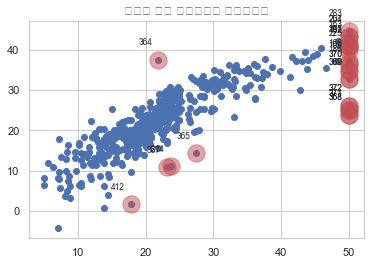

In [17]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

model_boston = sm.OLS(dfy, dfX)
result_boston = model_boston.fit()
pred = result_boston.predict(dfX)

influence_boston = result_boston.get_influence()
cooks_d2, pvals = influence_boston.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

# MEDV = 50 제거
idx = np.hstack([idx, np.where(boston.target == 50)[0]])

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy.MEDV[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy.MEDV[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("보스턴 집값 데이터에서 아웃라이어")
plt.show()

In [18]:
# 영향력을 제거한 뒤 분석 결과
idx2 = list(set(range(len(dfX))).difference(idx))
dfX = dfX.iloc[idx2, :].reset_index(drop=True)
dfy = dfy.iloc[idx2, :].reset_index(drop=True)
model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     156.1
Date:                Sat, 08 Aug 2020   Prob (F-statistic):          2.41e-161
Time:                        13:05:53   Log-Likelihood:                -1285.2
No. Observations:                 485   AIC:                             2598.
Df Residuals:                     471   BIC:                             2657.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8999      4.107      4.602      0.0